# <center>Minimum Transformation Method
## <center>An inverse model for inferring surface fluxes and mixing from gridded hydrographic TS data, <br> by Taimoor Sohail and Jan D. Zika



##### <center>We use an optimal transport method, minimzing a cost function which respects the volume and mass conservation, and the fundamental physics of mixing in TS space. <br>See also: Jan D Zika et al. (2021) [www.doi.org/10.1175/JCLI-D-20-0355.1 ] for a simpler version of this model which optimizes ocean circulation only.
------------

### __The code is laid out as follows:__
#### A) Pre-processing
i) Load necessary modules for computation \
ii) Define key parameters
#### B) Load Data
i) Load Mask \
ii) Load BSP Data
#### C) Define constraints
i) Define Connectivity \
ii) Define optimisation equations
#### D) Run optimisation
#### E) Plot inferred fluxes and mixing

#### F) Celebrate
----------
----------

## A) Pre-processing

### i) Load necessary modules for computation

Module to track runtime of cells and loops

In [1]:
import time
from tqdm.notebook import tqdm

Suppress warnings related to division by zero

In [2]:
import warnings
warnings.filterwarnings('ignore')


Module to load files and handle array computations

In [3]:
import xarray as xr
import numpy as np


Module to perform the optimization


In [4]:
import cvxpy as cp

Modules to plot outputs


In [5]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

Change universal plot fonts

In [6]:
# Specify font properties for plots
from matplotlib import rc
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 16}

rc('font', **font)

In [7]:
globe = False

### ii) Define key parameters

In [8]:
# Penalty on S vs T changes relative to beta/alpha (~4.28)
scalefact = 1
# Thermal expansion, haline contraction and true scale factor
alph = 1.7657*10**-4
bet = 7.5544*10**-4

if globe == True:
    xnorming = 1#10**15 #normalising coeffcients
    Areanorming = 1#10**12 #normalising coeffcients
    ST_scale=1#scalefact*(bet/alph)
else:
    xnorming = 10**15 #normalising coeffcients
    Areanorming = 10**12 #normalising coeffcients
    ST_scale=scalefact*(bet/alph)


# Establish basic constants and TS grid
yr2sec = 365.25*24*60*60
Cp=4000
rho=1024
S0=35



# Range of years of which 'early' and 'late' are defined
dyrs = 10

-----------
## B) Load Data


### i) Load Mask

In this analysis, we define 9 regions, the Polar Atlantic, Subtropical North Atlantic, Equatorial Atlantic, South Atlantic, Indian, South Pacific, Equatorial Pacific, North Pacific, Southern Ocean. Below we load this mask and plot the regions of interest.  

### ii) Load BSP Data


The data is presented as monthly T-S observations from EN4, from January 1970 to December 2014. The observations have already been binned via Binary Space Partitioning according to a specific criterion. Folowing Sohail et al. (TBD) the BSP partitioning occurs in an xyxyxyx order, shown to minimize variability in the temperature and salinity signals. The following datasets are currently avilable:

1) __Global Data (Volume)__\
This dataset (primarily to be used for debugging purposes) presents the global TS volumetric census, binned into 256 equal-volume bins via BSP, based on the global volume distribution. Thus, each BSP bin contains exactly the same volume, the bounds of which are allowed to change from month to month. \
_This dataset comes from files "BSP_ACCESS_TS_hist_gvol_*.nc"

2) __Regional Data (Regional Volume)__\
In this dataset, we conduct the global volume analysis above, but isolated to each of the 9 regions defined above. Thus, we obtain 9 sets of 256 BSP bins, each with equal volume. Each region is partitioned into equal volume bins based on that _region's_ volume, not the global volume distribution. \
_This dataset comes from files "BSP_ACCESS_TS_hist_vol_*.nc"


3) __Regional data (Global Surface Area)__\
In this dataset, we apply BSP to create 256 equal _global surface area_ bins. The data, however, is partitioned into the 9 regions defined above. Hence, each region will have the same 256 bins (which are calculated based on the global surface area distrubtion) but the area and volume captured by the bins will vary from region to region. The sum of the area over the 9 regions will be constant and equal for each BSP bin. \
_This dataset comes from files "BSP_ACCESS_TS_hist_area_*.nc"



In [9]:
%%time
if globe == True:
    EN4_data = xr.open_mfdataset('BSP_processed/BSP_EN4_TS_hist_gvol*.nc')
else:
    EN4_data = xr.open_mfdataset('BSP_processed/BSP_EN4_TS_hist_area*.nc')
    # EN4_data = xr.open_mfdataset('BSP_processed/BSP_EN4_TS_hist_vol*.nc')


# Early = first 1 year (1970 -1971)
Part_early = EN4_data.Partitions_hist.isel(Time=slice(0,12)).mean('Time')
SAearly =  EN4_data.T_mean_hist.isel(Time=slice(0,12)).mean('Time')
CTearly = EN4_data.S_mean_hist.isel(Time=slice(0,12)).mean('Time')
Vearly = EN4_data.V_sum_hist.isel(Time=slice(0,12)).mean('Time')

# Late = first 1 year (2013-2014)
Part_late = EN4_data.Partitions_hist.isel(Time=slice(-12,-1)).mean('Time')
SAlate = EN4_data.T_mean_hist.isel(Time=slice(-12,-1)).mean('Time')
CTlate = EN4_data.S_mean_hist.isel(Time=slice(-12,-1)).mean('Time')
Vlate = EN4_data.V_sum_hist.isel(Time=slice(-12,-1)).mean('Time')

if globe == False:
    Aearly = EN4_data.A_sum_hist.isel(Time=slice(0,12*dyrs)).mean('Time')
    Alate = EN4_data.A_sum_hist.isel(Time=slice(12*-dyrs,-1)).mean('Time')
    Basins = EN4_data.Basin.values

Wall time: 3.84 s


In [10]:


if globe == False:
    # Flatten the early and late variables to a 1D array
    flat_Vol_blc1 = Vearly.values.flatten()
    flat_Vol_blc2 = Vlate.values.flatten()
    flat_S_blc1 = SAearly.values.flatten()-35
    flat_S_blc2 = SAlate.values.flatten()-35
    flat_T_blc1 = CTearly.values.flatten()
    flat_T_blc2 = CTlate.values.flatten()
    flat_A_blc1 = Aearly.values.flatten()
    flat_A_blc2 = Alate.values.flatten()


        # Do the same for basin index
    Basin_blc1 = np.zeros_like(Vearly)
    Basin_blc2 = np.zeros_like(Vearly)
    flat_Basin_blc_names = []
    for i in range(np.array(Basins).size):
        Basin_blc1[i,:] = i
        Basin_blc2[i,:] = i
        for j in range(Vearly.shape[-1]):
            flat_Basin_blc_names.append(Basins[i])

    #... and for basin name
    flat_Basin_blc1 = Basin_blc1.flatten()
    flat_Basin_blc2 = Basin_blc2.flatten()

    #... and for the edges of the BSP bins
    flat_S_st_basin = (0.5*(Part_early.values[:,:,0]+Part_late.values[:,:,0])).flatten()-35
    flat_S_end_basin = (0.5*(Part_early.values[:,:,1]+Part_late.values[:,:,1])).flatten()-35
    flat_T_st_basin = (0.5*(Part_early.values[:,:,2]+Part_late.values[:,:,2])).flatten()
    flat_T_end_basin = (0.5*(Part_early.values[:,:,3]+Part_late.values[:,:,3])).flatten()
else:
    flat_Vol_blc1 = Vearly.values.flatten()
    flat_Vol_blc2 = Vlate.values.flatten()
    flat_S_blc1 = CTearly.values.flatten()-35
    flat_S_blc2 = CTlate.values.flatten()-35
    flat_T_blc1 = SAearly.values.flatten()
    flat_T_blc2 = SAlate.values.flatten()
    #... and for the edges of the BSP bins
    flat_S_st_basin = (0.5*(Part_early.values[:,0]+Part_late.values[:,0])).flatten()-35
    flat_S_end_basin = (0.5*(Part_early.values[:,1]+Part_late.values[:,1])).flatten()-35
    flat_T_st_basin = (0.5*(Part_early.values[:,2]+Part_late.values[:,2])).flatten()
    flat_T_end_basin = (0.5*(Part_early.values[:,3]+Part_late.values[:,3])).flatten()

# Any NaNs are zeroed out
flat_S_blc1[np.isnan(flat_S_blc1)] = 0
flat_S_blc2[np.isnan(flat_S_blc2)] = 0
flat_T_blc1[np.isnan(flat_T_blc1)] = 0
flat_T_blc2[np.isnan(flat_T_blc2)] = 0

# SIMPLE EXAMPLE
## Here, we override the BSP bins to explore two simple examples: No mixing, and no fluxes. 
### Note: xnorming, ST_scale have been set to 1

In [11]:
# OVERRIDING SIMPLE NO FLUX EXAMPLE (2 WMs)
# flat_Vol_blc1 = np.array([5,5])
# flat_Vol_blc2 = np.array([0,10])
# flat_S_blc1 = np.array([1,1])
# flat_S_blc2 = np.array([1,1])
# flat_T_blc1 = np.array([3,7])
# flat_T_blc2 = np.array([5,5])

# OVERRIDING SIMPLE NO MIXING EXAMPLE (2 WMs)
# flat_Vol_blc1 = np.array([5,0])
# flat_Vol_blc2 = np.array([0,5])
# flat_S_blc1 = np.array([1,2])
# flat_S_blc2 = np.array([2,3])
# flat_T_blc1 = np.array([1,1])
# flat_T_blc2 = np.array([2,2])

# OVERRIDING SIMPLE NO FLUX EXAMPLE (4 WMs)
# flat_Vol_blc1 = np.array([1,1,1,1])
# flat_Vol_blc2 = np.array([0,2,0,2])
# flat_S_blc1 = np.array([1,1,4,4])
# flat_S_blc2 = np.array([-2,1,-2,4])
# flat_T_blc1 = np.array([1,3,1,3])
# flat_T_blc2 = np.array([-2,2,-2,2])

# OVERRIDING SIMPLE NO MIXING EXAMPLE (4 WMs)
# flat_Vol_blc1 = np.array([1,2,3,4])
# flat_Vol_blc2 = np.array([4,3,2,1])
# flat_S_blc1 = np.array([1,1,2,2])
# flat_S_blc2 = np.array([2,2,3,3])
# flat_T_blc1 = np.array([1,3,1,3])
# flat_T_blc2 = np.array([2,4,2,4])

In [12]:
print('Total number of bins =', int(flat_Vol_blc1.shape[0]))

Total number of bins = 1152


#### Plot time-mean volume

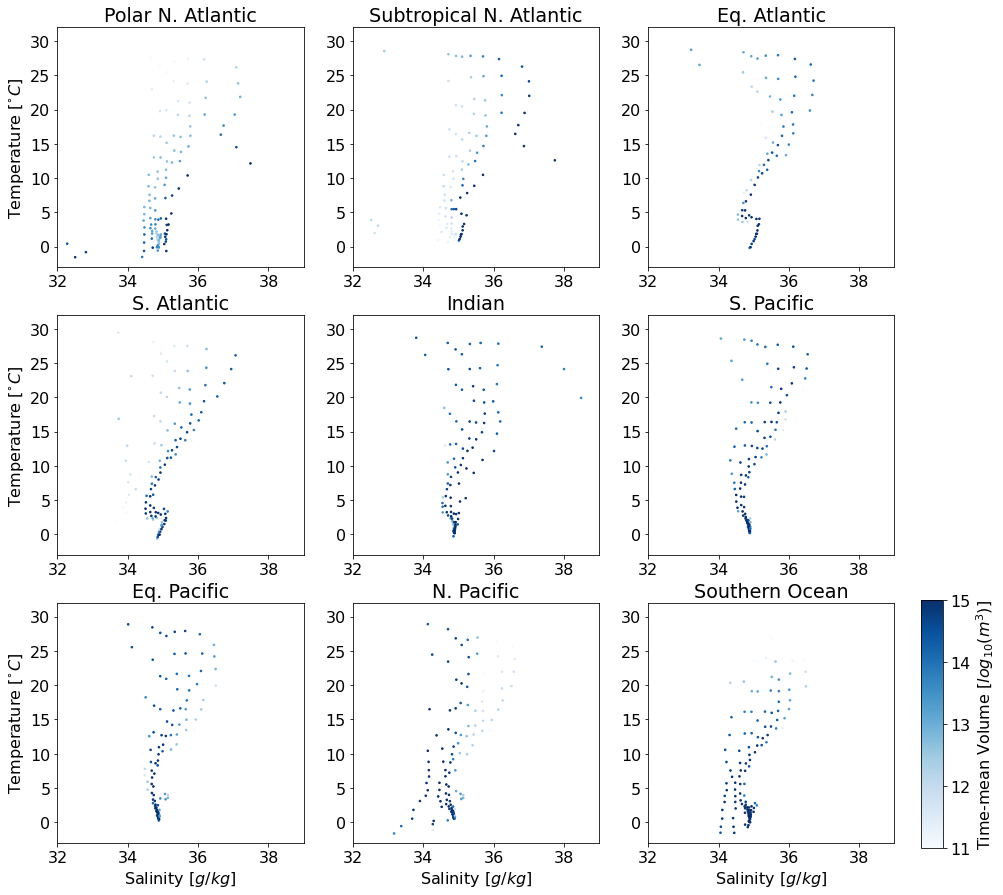

In [13]:
if globe == False:
    fig, axs = plt.subplots(3,3, figsize=(15,15), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .2, wspace=0.2)
    axs = axs.ravel() 
    cax = fig.add_axes([0.925, 0.12, 0.02, 0.23])

    minv, maxv = 11,15
    cmap = 'Blues'

    for bx in range(Basins.size):
        axs[bx].scatter(SAearly[bx,:],CTearly[bx,:], 10, np.log10(Vearly[bx,:]),cmap=cmap, vmin=minv, vmax=maxv, marker = '.')
        axs[bx].set_xlim(32,39)
        axs[bx].set_ylim(-3,32)
        axs[bx].set_title(Basins[bx])
        if bx==0 or bx==3 or bx==6:
            axs[bx].set_ylabel('Temperature [$^{\circ}C$]')
        if bx==6 or bx==7 or bx==8:
            axs[bx].set_xlabel('Salinity [$g/kg$]')
            
    m = plt.cm.ScalarMappable(cmap=cmap)
    m.set_clim(minv, maxv)
    cbar = fig.colorbar(m, cax=cax, orientation='vertical')
    cbar.set_label('Time-mean Volume [$log_{10}(m^3)$]') 
    # plt.savefig('../../Figures/BSP_clustering_mean_volumes_Vbased.png', bbox_inches='tight', dpi=300)
    plt.show()

In [14]:
if globe == True:
    minv, maxv = 11,18
    cmap = 'Blues'

    plt.scatter(CTearly,SAearly, 10, np.log10(Vearly),cmap=cmap, vmin=minv, vmax=maxv, marker = '.')
    plt.xlim(32,39)
    plt.ylim(-3,32)
    plt.title('Global')
    plt.ylabel('Temperature [$^{\circ}C$]')
    plt.xlabel('Salinity [$g/kg$]')
    cbar = plt.colorbar()
    cbar.set_label('Time-mean Volume [$log_{10}(m^3)$]') 

    # plt.savefig('../../Figures/BSP_clustering_mean_volumes_Vbased.png', bbox_inches='tight', dpi=300)

    plt.show()

---------------
## C) Define Constraints

### i) Define Connectivity

We must define whether a BSP bin is allowed to transport volume to another BSP bin. In the simplest case, all bins are allowed to transport to one another - but this yields nonphysical transport across vast distances and TS bounds.
To improve on this, two connectivity constraints are used: 
1) Are the basins adjacent? This is defined via the connectivity array, below
2) If YES, do the BSP bins have overlapping (or the same) TS boundaries?\
If yes, the bins are connected. If no, they are not.


In [15]:
if globe == False:
    # Array defining the connection between the 9 basins; 0=connected, 1=disconnected
    connectivity_array = np.zeros((9,9))

    connectivity_array[0,:] = [0, 0, 1, 1, 1, 1, 1, 1, 1]
    connectivity_array[1,:] = [0, 0, 0, 1, 1, 1, 1, 1, 1]
    connectivity_array[2,:] = [1, 0, 0, 0, 1, 1, 1, 1, 1]
    connectivity_array[3,:] = [1, 1, 0, 0, 1, 1, 1, 1, 0]
    connectivity_array[4,:] = [1, 1, 1, 1, 0, 1, 0, 1, 0]
    connectivity_array[5,:] = [1, 1, 1, 1, 1, 0, 0, 1, 0]
    connectivity_array[6,:] = [1, 1, 1, 1, 0, 0, 0, 0, 1]
    connectivity_array[7,:] = [1, 1, 1, 1, 1, 1, 0, 0, 1]
    connectivity_array[8,:] = [1, 1, 1, 0, 0, 0, 1, 1, 0]

In [16]:
#%%time
if globe == True:
    connected = np.ones((flat_Vol_blc1.size, flat_Vol_blc1.size))
else:
    # Define whether a bin is connected to every other bin
    # The two constraints used are: are the basins adjacent? 
    # If yes, are the T and S edges of the bin overlapping (or the same) as this bin? 
    # If yes, the bins are connected; if no, they are not connected. 
    connected = np.zeros((flat_Vol_blc1.size, flat_Vol_blc1.size))
    connected_Sst = np.zeros_like(connected)
    connected_Tst = np.zeros_like(connected)
    connected_Send = np.zeros_like(connected)
    connected_Tend = np.zeros_like(connected)
    for i in tqdm(range(flat_Vol_blc1.size)):
        for j in range(flat_Vol_blc2.size):
            if connectivity_array[int(flat_Basin_blc1[i]), int(flat_Basin_blc1[j])]==0:
                if flat_Basin_blc_names[i] == flat_Basin_blc_names[j]:
                    connected[i,j] = 1
                elif flat_S_st_basin[i]==flat_S_st_basin[j] and flat_T_st_basin[i]==flat_T_st_basin[j]:
                    connected[i,j] = 1

  0%|          | 0/1152 [00:00<?, ?it/s]

### ii) Define optimisation equations

Define optimisation equation to minimise Ax-b, and constraint such that volume must be conserved, Cx-d=0. 
In this case, A is the area-averaged T and S and b is the area-averaged, volume-weighted T and S (i.e. TV, SV).
C is the connectivity between basins (1 or 0), and d is the volume of the bins

In [17]:
%%time

nofaces = np.nansum(connected)
A1_connec=np.zeros((flat_Vol_blc1.size,int(nofaces)))
A2_connec=np.zeros((flat_Vol_blc2.size,int(nofaces)))
# Also make T and S matrix with the T(k,i) the temp of the ith early WM
Tmatrix=np.zeros((flat_Vol_blc1.size,int(nofaces)))
Smatrix=np.zeros((flat_Vol_blc1.size,int(nofaces)))
ix=0
for i in tqdm(range(flat_Vol_blc1.size)):
    for j in range(flat_Vol_blc2.size):
        if globe == False:
            if connected[i,j]==1:
                A1_connec[i,ix] = 1 # vertex ix connects from WM i
                A2_connec[j,ix] = 1 # vertex ix connects to WM j
                Tmatrix[j,ix] = flat_T_blc1[i] #vertex ix brings temp of WM i to WM j
                Smatrix[j,ix] = flat_S_blc1[i] #vertex ix brings temp of WM i to WM j
                ix=ix+1
        else:
            if connected[i,j]==1:
                A1_connec[i,ix] = 1 # vertex ix connects from WM i
                A2_connec[j,ix] = 1 # vertex ix connects to WM j
                Tmatrix[j,ix] = flat_T_blc1[i] #vertex ix brings temp of WM i to WM j
                Smatrix[j,ix] = flat_S_blc1[i] #vertex ix brings temp of WM i to WM j
                ix=ix+1

AA = np.concatenate((A1_connec,A2_connec),axis=0)
CC_T = np.zeros_like(Tmatrix)
CC_S = np.zeros_like(Tmatrix)
for i in tqdm(range(int(nofaces))):
    if globe == True:
        CC_T[:,i] = Tmatrix[:,i]
        CC_S[:,i] = ST_scale*(Smatrix[:,i])
    else:
        CC_T[:,i] = Areanorming*Tmatrix[:,i]/(flat_A_blc1+10**10)
        CC_S[:,i] = Areanorming*ST_scale*(Smatrix[:,i])/(flat_A_blc1+10**10)

CC = np.concatenate((CC_T,CC_S),axis=0)
#plus 10**10 to prevent divide by zero
bb = np.concatenate((flat_Vol_blc1/xnorming,flat_Vol_blc2/xnorming),axis=0)
if globe == True:
    dd = np.concatenate((flat_Vol_blc2*flat_T_blc2,\
                            ST_scale*flat_Vol_blc2*flat_S_blc2), axis=0)/xnorming
else:
    dd = Areanorming*np.concatenate((flat_Vol_blc2*flat_T_blc2/(flat_A_blc2+10**10),\
                            ST_scale*flat_Vol_blc2*flat_S_blc2/(flat_A_blc2+10**10)), axis=0)/xnorming
dd[np.isnan(dd)]=0

  0%|          | 0/1152 [00:00<?, ?it/s]

  0%|          | 0/149760 [00:00<?, ?it/s]

Wall time: 19.5 s


-----------------
## D) Run Optimisation

In [18]:
%%time
m = CC.shape[0]
n = CC.shape[1]

A = CC
C = AA
d = bb
b = dd
x = cp.Variable(n, nonneg=True)

cost = cp.sum_squares(A@x-b)
constraints = [C@x==d]
prob = cp.Problem(cp.Minimize(cost), constraints)

# The optimal objective value is returned by prob.solve()`.
# OSQP, ECOS, ECOS_BB, MOSEK, CBC, CVXOPT, NAG, GUROBI, and SCS
result = prob.solve(verbose=True, solver=cp.MOSEK)

if prob.status not in ["infeasible", "unbounded"]:
    # Otherwise, problem.value is inf or -inf, respectively.
    print("Optimal value: %s" % prob.value)
for variable in prob.variables():
    print("Variable %s: value %s" % (variable.name(), variable.value))

# The optimal value for x is stored in `x.value`.
xxx=x.value
print(xxx)


                                     CVXPY                                     
                                     v1.2.0                                    
(CVXPY) Apr 21 07:56:36 AM: Your problem has 149760 variables, 1 constraints, and 0 parameters.
(CVXPY) Apr 21 07:56:37 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Apr 21 07:56:37 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Apr 21 07:56:37 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Apr 21 07:56:37 AM: Compiling problem (target solver=MOSEK).
(CVXPY) Apr 21 07:56:37 AM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffi

(CVXPY) Apr 21 07:56:58 AM: 26  6.7e-13  1.5e-02  1.0e-05  1.76e-01   1.008364974e+00   1.008410263e+00   5.1e-04  3.00  
(CVXPY) Apr 21 07:56:58 AM: 27  5.8e-13  9.8e-03  6.7e-06  9.59e-02   1.101942403e+00   1.101969235e+00   3.3e-04  3.11  
(CVXPY) Apr 21 07:56:58 AM: 28  4.3e-13  6.3e-03  4.3e-06  -1.01e-01  1.221553740e+00   1.221567412e+00   2.2e-04  3.19  
(CVXPY) Apr 21 07:56:58 AM: 29  2.6e-13  3.5e-03  2.2e-06  -6.64e-02  1.396703107e+00   1.396707710e+00   1.2e-04  3.28  
(CVXPY) Apr 21 07:56:58 AM: 30  3.7e-13  1.7e-03  9.1e-07  4.06e-02   1.636118205e+00   1.636116901e+00   6.0e-05  3.36  
(CVXPY) Apr 21 07:56:58 AM: 31  1.8e-12  1.2e-03  6.0e-07  1.88e-01   1.771223607e+00   1.771220531e+00   4.2e-05  3.45  
(CVXPY) Apr 21 07:56:59 AM: 32  2.7e-13  1.1e-03  5.0e-07  1.63e-01   1.819370070e+00   1.819368222e+00   3.7e-05  3.53  
(CVXPY) Apr 21 07:56:59 AM: 33  2.0e-13  9.6e-04  4.4e-07  2.15e-01   1.861015091e+00   1.861013321e+00   3.3e-05  3.61  
(CVXPY) Apr 21 07:56:59 

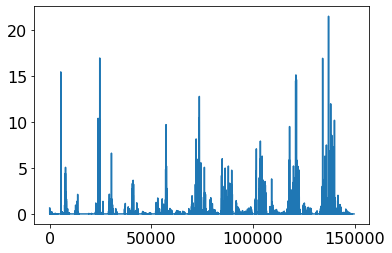

In [19]:
plt.plot(xxx)

##### Define the mixing and adjustment of T and S

In [20]:
Tmixed = np.matmul(Tmatrix,xxx)/(flat_Vol_blc2/xnorming) #Changed from flat_vol_blc1
Tmixed[~np.isfinite(Tmixed)]= np.nan
Tmixed[Tmixed>100] = np.nan
Smixed = np.matmul(Smatrix,xxx)/(flat_Vol_blc2/xnorming) #Changed from flat_vol_blc1
Smixed[~np.isfinite(Smixed)]= np.nan
Smixed[Smixed>10**4] = np.nan

# Now the necessary heat and salt adjustment is simply the difference
# between this and what we actually get
dTV_adj = (flat_T_blc2-Tmixed)*flat_Vol_blc2
dSV_adj = (flat_S_blc2-Smixed)*flat_Vol_blc2


# Dividing by the volume we get the average temperature change.
T_Av_adj = dTV_adj/(flat_Vol_blc2)
T_Av_adj[np.isnan(T_Av_adj)] = 0
S_Av_adj = dSV_adj/(flat_Vol_blc2)
S_Av_adj[np.isnan(S_Av_adj)]= 0

In [21]:
plt.figure(figsize=(10,5))
if globe == True:
      plt.scatter(flat_S_blc1,flat_T_blc1,\
            s=50,\
            marker = 'o', facecolor='none', edgecolor='black', label = 't2', zorder=100)
      plt.scatter(flat_S_blc2,flat_T_blc2,\
            s=50,\
            marker = 'o', facecolor='none', edgecolor='magenta', label = 't1', zorder=100)
      for i in range(flat_S_blc2.size):
            if ~np.isnan(Tmixed[i]) | ~np.isnan(Smixed[i]):

                  plt.annotate('', xy=(flat_S_blc1[i], flat_T_blc1[i]), xytext=(Smixed[i], Tmixed[i]),
      arrowprops=dict(arrowstyle="<-", color='blue'))
                  plt.annotate('', xy=(Smixed[i], Tmixed[i]), xytext=(Smixed[i]+S_Av_adj[i], Tmixed[i]+T_Av_adj[i]),
      arrowprops=dict(arrowstyle="<-", color='red'))
            else:
                  plt.annotate('', xy=(flat_S_blc1[i], flat_T_blc1[i]), xytext=(flat_S_blc1[i]+S_Av_adj[i], flat_T_blc1[i]+T_Av_adj[i]),
      arrowprops=dict(arrowstyle="<-", color='red'))
      plt.xlim(-1,5)
      plt.ylim(-1,8)
      plt.title('Global')
      plt.grid()
      plt.show()

<Figure size 720x360 with 0 Axes>

---------------------
## E) Plot inferred fluxes and mixing

##### Surface Fluxes of Salinity

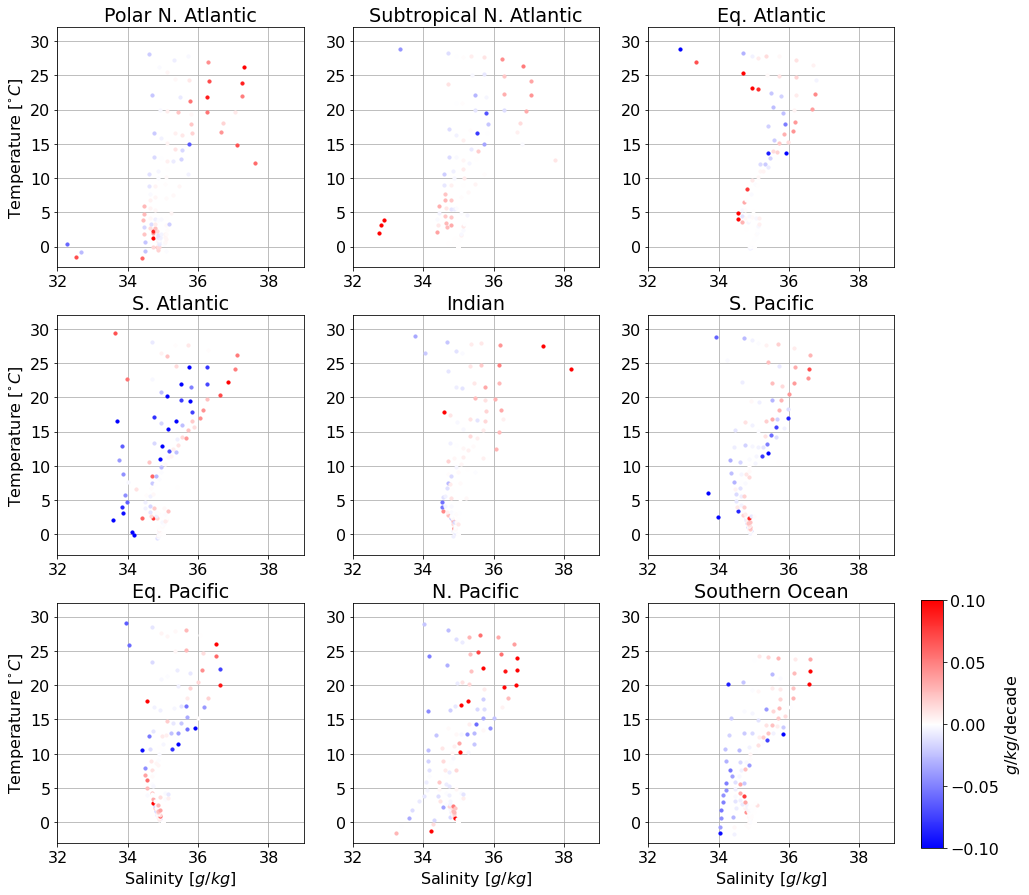

Wall time: 13.8 s


In [22]:
%%time
if globe == False:

    fig, axs = plt.subplots(3,3, figsize=(15,15), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .2, wspace=0.2)
    axs = axs.ravel() 
    cax = fig.add_axes([0.925, 0.12, 0.02, 0.23])

    minv, maxv = -.1,.1
    cmap = plt.cm.bwr
    norm = plt.Normalize(minv, maxv)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])

    k=0
    for i in range(np.array(Basins).size):
        for j in range(128):
            axs[i].scatter(0.5*(flat_S_blc1[k]+flat_S_blc2[k]+70), 0.5*(flat_T_blc1[k]+flat_T_blc2[k]), 10, color=cmap(norm(10*S_Av_adj[k]/44)), zorder=100)
            # axs[i].add_patch(patches.Rectangle((x0[j], y0[j]), w[j], h[j], ec=None, color=cmap(norm(10*S_Av_adj[k]/dyrs))))
            axs[i].set_xlim(32,39)
            axs[i].set_ylim(-3,32)
            axs[i].set_title(Basins[i])
            axs[i].grid(True)
            k=k+1
        if i==0 or i==3 or i==6:
            axs[i].set_ylabel('Temperature [$^{\circ}C$]')
        if i==6 or i==7 or i==8:
            axs[i].set_xlabel('Salinity [$g/kg$]')
    m = plt.cm.ScalarMappable(cmap='bwr')
    m.set_clim(minv, maxv)
    cbar = fig.colorbar(m, cax=cax, orientation='vertical')
    cbar.set_label('$g/kg$/decade') 
    # plt.savefig('../../Figures/Minimisation_9basins.png', dpi=300, bbox_inches='tight')
    plt.show()

In [23]:
if globe == True:
    minv, maxv = -.01,.01
    cmap = plt.cm.bwr
    norm = plt.Normalize(minv, maxv)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])

    plt.scatter(0.5*(flat_S_blc1+flat_S_blc2+35*2), 0.5*(flat_T_blc1+flat_T_blc2), 10, color=cmap(norm(10*S_Av_adj/dyrs)), zorder=100)
    plt.xlim(32,39)
    plt.ylim(-3,32)
    plt.title('Global')
    plt.grid(True)
    plt.ylabel('Temperature [$^{\circ}C$]')
    plt.xlabel('Salinity [$g/kg$]')
    plt.show()


##### Surface Fluxes of Temperature

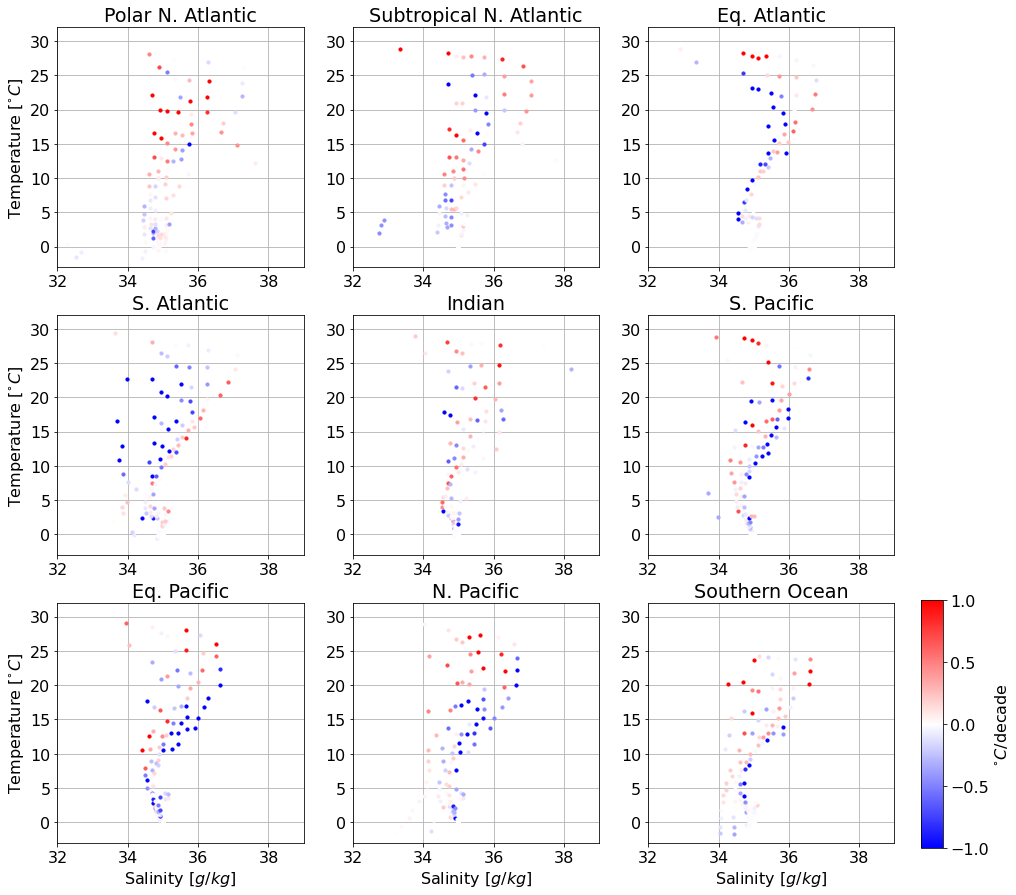

In [24]:
# %%time
if globe == False:
    fig, axs = plt.subplots(3,3, figsize=(15,15), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .2, wspace=0.2)
    axs = axs.ravel() 
    cax = fig.add_axes([0.925, 0.12, 0.02, 0.23])

    minv, maxv = -1,1
    cmap = plt.cm.bwr
    norm = plt.Normalize(minv, maxv)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])

    k=0
    for i in range(np.array(Basins).size):
        for j in range(128):
            axs[i].scatter(0.5*(flat_S_blc1[k]+flat_S_blc2[k]+35*2), 0.5*(flat_T_blc1[k]+flat_T_blc2[k]), 10, color=cmap(norm(10*T_Av_adj[k]/44)), zorder=100)
            # axs[i].add_patch(patches.Rectangle((x0[j], y0[j]), w[j], h[j], ec=None, color=cmap(norm(10*S_Av_adj[k]/dyrs))))
            axs[i].set_xlim(32,39)
            axs[i].set_ylim(-3,32)
            axs[i].set_title(Basins[i])
            axs[i].grid(True)
            k=k+1
        if i==0 or i==3 or i==6:
            axs[i].set_ylabel('Temperature [$^{\circ}C$]')
        if i==6 or i==7 or i==8:
            axs[i].set_xlabel('Salinity [$g/kg$]')
    m = plt.cm.ScalarMappable(cmap='bwr')
    m.set_clim(minv, maxv)
    cbar = fig.colorbar(m, cax=cax, orientation='vertical')
    cbar.set_label('$^{\circ}C$/decade') 
    # plt.savefig('../../Figures/Minimisation_9basins.png', dpi=300, bbox_inches='tight')
    plt.show()

In [25]:
if globe == True:
    minv, maxv = -.05,.05
    cmap = plt.cm.bwr
    norm = plt.Normalize(minv, maxv)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])

    plt.scatter(0.5*(flat_S_blc1+flat_S_blc2), 0.5*(flat_T_blc1+flat_T_blc2), 10, color=cmap(norm(10*T_Av_adj/dyrs)), zorder=100)
    # plt.xlim(32,39)
    # plt.ylim(-3,32)
    plt.title('Global')
    plt.grid(True)
    plt.ylabel('Temperature [$^{\circ}C$]')
    plt.xlabel('Salinity [$g/kg$]')
    plt.show()

##### Surface flux and mixing vectors

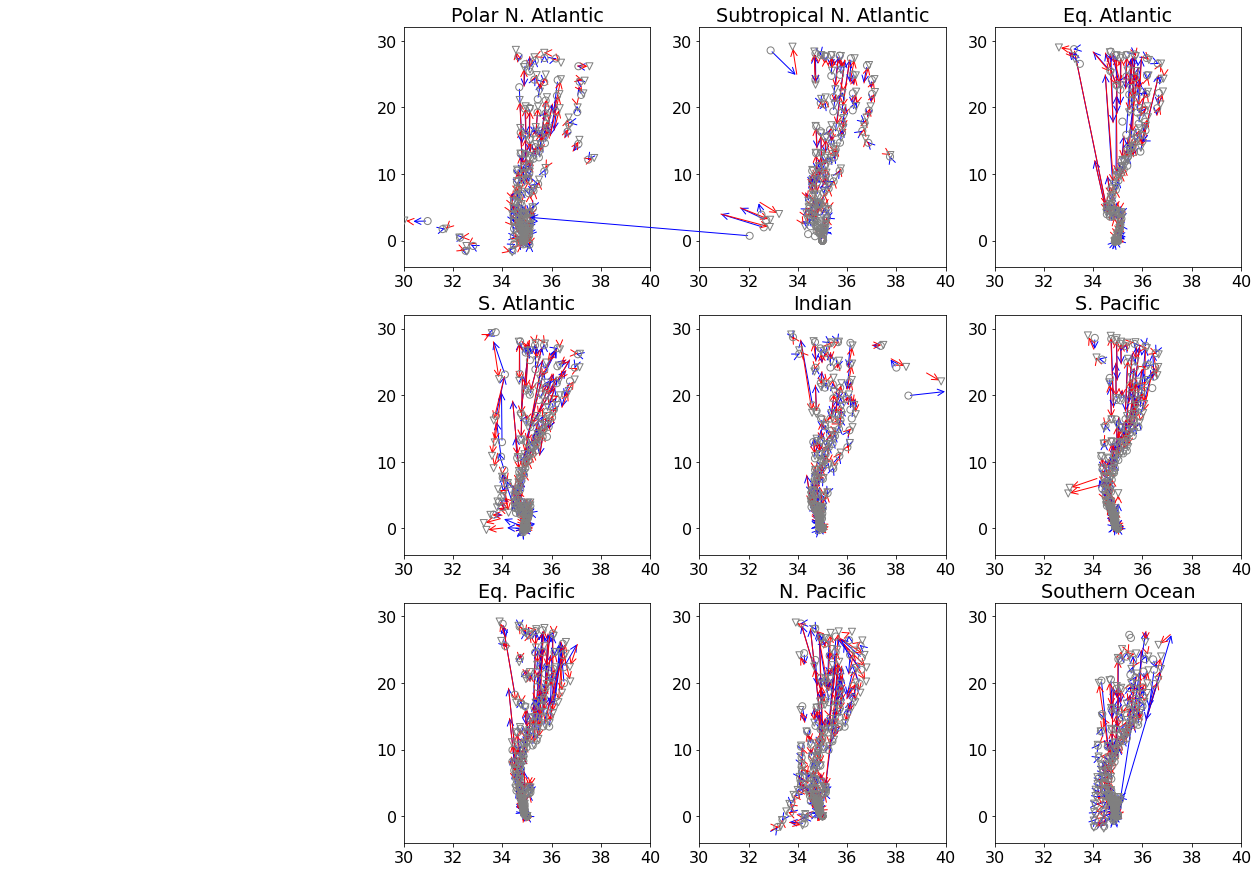

In [26]:
#%%time
if globe == False:
    fig, axs = plt.subplots(3,3, figsize=(15,15), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .2, wspace=0.2)
    axs = axs.ravel() 

    k=0
    for i in range(np.array(Basins).size):
        for j in range(128):
            axs[i].scatter(flat_S_blc1[k]+35,flat_T_blc1[k],\
                   s=50,\
                  marker = 'o', facecolor='none', edgecolor='grey', label = 't2', zorder=100)
            axs[i].scatter(flat_S_blc2[k]+35,flat_T_blc2[k],\
                   s=50,\
                  marker = 'v', facecolor='none', edgecolor='grey', label = 't1', zorder=100)
            if ~np.isnan(Tmixed[k]) | ~np.isnan(Smixed[k]):
                axs[i].annotate('', xy=(flat_S_blc1[k]+35, flat_T_blc1[k]), xytext=(Smixed[k]+35, Tmixed[k]),
      arrowprops=dict(arrowstyle="<-", color='blue'))
                axs[i].annotate('', xy=(Smixed[k]+35, Tmixed[k]), xytext=(Smixed[k]+S_Av_adj[k]+35, Tmixed[k]+T_Av_adj[k]),
      arrowprops=dict(arrowstyle="<-", color='red'))
            else:
                axs[i].annotate('', xy=(flat_S_blc1[k]+35, flat_T_blc1[k]), xytext=(flat_S_blc1[k]+S_Av_adj[k]+35, flat_T_blc1[k]+T_Av_adj[k]),
      arrowprops=dict(arrowstyle="<-", color='red'))
            axs[i].set_xlim(30,40)
            axs[i].set_ylim(-4,32)
            axs[i].set_title(Basins[i])
            k=k+1

    # plt.savefig('../../Figures/Minimisation_vectors.png', dpi=300, bbox_inches='tight')
    plt.show()
# %%


In [27]:
%%time
plt.figure(figsize=(10,5))
if globe == True:
      plt.scatter(flat_S_blc1,flat_T_blc1,\
            s=50,\
            marker = 'o', facecolor='none', edgecolor='black', label = 't2', zorder=100)
      plt.scatter(flat_S_blc2,flat_T_blc2,\
            s=50,\
            marker = 'o', facecolor='none', edgecolor='magenta', label = 't1', zorder=100)
      for i in range(flat_S_blc2.size):
            if ~np.isnan(Tmixed[i]) | ~np.isnan(Smixed[i]):
                  hyp_mix = np.sqrt(S_Av_mix[i]**2+T_Av_mix[i]**2)
                  hyp_adj = np.sqrt(S_Av_adj[i]**2+T_Av_adj[i]**2)

                  plt.annotate('', xy=(flat_S_blc1[i], flat_T_blc1[i]), xytext=(Smixed[i], Tmixed[i]),
      arrowprops=dict(arrowstyle="<-", color='blue'))
                  plt.annotate('', xy=(Smixed[i], Tmixed[i]), xytext=(Smixed[i]+S_Av_adj[i], Tmixed[i]+T_Av_adj[i]),
      arrowprops=dict(arrowstyle="<-", color='red'))
            else:
                  plt.annotate('', xy=(flat_S_blc1[i], flat_T_blc1[i]), xytext=(flat_S_blc1[i]+S_Av_adj[i], flat_T_blc1[i]+T_Av_adj[i]),
      arrowprops=dict(arrowstyle="<-", color='red'))

      plt.xlim(-1,5)
      plt.ylim(-1,5)
      plt.title('Global')
      plt.grid()
      plt.show()


Wall time: 0 ns


<Figure size 720x360 with 0 Axes>

In [28]:
# Furthermore we want to know how much T and S change the mixing actually
# causes for the early water masses as they turn into late water masses.
Tmixed[~np.isfinite(Tmixed)]= 0
Smixed[~np.isfinite(Smixed)]= 0

ix=0
dT_between=np.zeros((flat_Vol_blc2.size,int(nofaces)))
dS_between=np.zeros((flat_Vol_blc2.size,int(nofaces)))
for i in range(flat_Vol_blc1.size):
    for j in range(flat_Vol_blc2.size):
        if connected[i,j]==1:
            dT_between[i,ix] = Tmixed[j]-flat_T_blc1[i]
            #temp where it gets to minus where it came from
            dS_between[i,ix] = Smixed[j]-flat_S_blc1[i]
            ix=ix+1

dTV_mix = np.matmul(dT_between,xxx)*xnorming
dSV_mix = np.matmul(dS_between,xxx)*xnorming

# Do the same for the mixing onto the early WMs
T_Av_mix = dTV_mix/(flat_Vol_blc2)
T_Av_mix[np.isnan(T_Av_mix)] = 0
T_Av_mix[T_Av_mix==np.inf] = 0
S_Av_mix = dSV_mix/(flat_Vol_blc2)
S_Av_mix[np.isnan(S_Av_mix)]= 0
S_Av_mix[S_Av_mix==np.inf] = 0

In [29]:
print(np.nansum(Tmixed*flat_Vol_blc2))
print(np.nansum(dTV_mix))
print(np.nansum(flat_T_blc1*flat_Vol_blc1))
print(np.nansum(flat_T_blc2*flat_Vol_blc2)-np.nansum(flat_T_blc1*flat_Vol_blc1))

4.878689749296243e+18
434957060068.0
4.878689542950001e+18
6.930719591228518e+16


In [30]:
EN4_3D_data = xr.open_mfdataset('../EN4_Data/EN_data/EN4_CT*.nc')
EN4_3D_mask = xr.open_mfdataset('../Min_Transform_Method/mask*')
partitions_bins = EN4_data.Partitions_hist.isel(Time=slice(0,12)).mean('Time').isel(Basin=0).values
EN4_3D_mask_numpy = EN4_3D_mask.__xarray_dataarray_variable__.values
EN4_3D_SA_mean = EN4_3D_data.Abs_Sal.isel(time=slice(0,12)).mean('time')
EN4_3D_CT_mean = EN4_3D_data.Cons_Temp.isel(time=slice(0,12)).mean('time')

OSError: no files to open

In [ ]:
T_Av_adj_2D = T_Av_adj.reshape(Basins.size, 128)
S_Av_adj_2D = S_Av_adj.reshape(Basins.size, 128)
T_Av_mix_2D = T_Av_mix.reshape(Basins.size, 128)
S_Av_mix_2D = S_Av_mix.reshape(Basins.size, 128)


In [ ]:
masked_T_adj_grid_bsum =0
masked_T_adj_grid_sum = 0
for j in tqdm(range(128)):
    for k in range(Basins.size):
        masked_T_adj_grid = xr.where((EN4_3D_SA_mean>partitions_bins[j,0])&\
                                (EN4_3D_SA_mean<partitions_bins[j,1])&\
                                (EN4_3D_CT_mean>partitions_bins[j,2])&\
                                (EN4_3D_CT_mean<partitions_bins[j,3]), \
                                T_Av_adj_2D[k,j]*EN4_3D_mask_numpy[k,:,:,:], 0)
        masked_T_adj_grid_bsum = masked_T_adj_grid_bsum+masked_T_adj_grid
    masked_T_adj_grid_sum = masked_T_adj_grid_bsum+masked_T_adj_grid_sum

# masked_S_adj_grid_bsum =0
# masked_S_adj_grid_sum = 0
# for j in tqdm(range(128)):
#     for k in range(Basins.size):
#         masked_S_adj_grid = xr.where((EN4_3D_SA_mean>partitions_bins[j,0])&\
#                                 (EN4_3D_SA_mean<partitions_bins[j,1])&\
#                                 (EN4_3D_CT_mean>partitions_bins[j,2])&\
#                                 (EN4_3D_CT_mean<partitions_bins[j,3]), \
#                                 S_Av_adj_2D[k,j]*EN4_3D_mask_numpy[k,:,:,:], 0)
#         masked_S_adj_grid_bsum = masked_S_adj_grid_bsum+masked_S_adj_grid
#     masked_S_adj_grid_sum = masked_S_adj_grid_bsum+masked_S_adj_grid_sum

In [ ]:
masked_T_mix_grid_bsum =0
masked_T_mix_grid_sum = 0
for j in tqdm(range(128)):
    for k in range(Basins.size):
        masked_T_mix_grid = xr.where((EN4_3D_SA_mean>partitions_bins[j,0])&\
                                (EN4_3D_SA_mean<partitions_bins[j,1])&\
                                (EN4_3D_CT_mean>partitions_bins[j,2])&\
                                (EN4_3D_CT_mean<partitions_bins[j,3]), \
                                T_Av_mix_2D[k,j]*EN4_3D_mask_numpy[k,:,:,:], 0)
        masked_T_mix_grid_bsum = masked_T_mix_grid_bsum+masked_T_mix_grid
    masked_T_mix_grid_sum = masked_T_mix_grid_bsum+masked_T_mix_grid_sum
# masked_T_mix_grid_sum = masked_T_mix_grid_sum/(T_Av_mix.size)

# masked_S_mix_grid_bsum =0
# masked_S_mix_grid_sum = 0
# for j in tqdm(range(128)):
#     for k in range(Basins.size):
#         masked_S_mix_grid = xr.where((EN4_3D_SA_mean>partitions_bins[j,0])&\
#                                 (EN4_3D_SA_mean<partitions_bins[j,1])&\
#                                 (EN4_3D_CT_mean>partitions_bins[j,2])&\
#                                 (EN4_3D_CT_mean<partitions_bins[j,3]), \
#                                 S_Av_mix_2D[k,j]*EN4_3D_mask_numpy[k,:,:,:], 0)
#         masked_S_mix_grid_bsum = masked_S_mix_grid_bsum+masked_S_mix_grid
#     masked_S_mix_grid_sum = masked_S_mix_grid_bsum+masked_S_mix_grid_sum
# masked_S_mix_grid_sum = masked_S_mix_grid_sum/(S_Av_mix.size)

In [ ]:
masked_T_adj_grid_DA = ((masked_T_adj_grid_sum*EN4_3D_data.dVol.isel(time=0)).sum('depth')/(EN4_3D_data.dVol.isel(time=0)).sum('depth')).values
# masked_S_adj_grid_DA = ((masked_S_adj_grid_sum*EN4_3D_data.dVol.isel(time=0)).sum('depth')/(EN4_3D_data.dVol.isel(time=0)).sum('depth')).values
masked_T_mix_grid_DA = (((masked_T_mix_grid_sum*EN4_3D_data.dVol.isel(time=0)).sum('depth')*EN4_3D_data.dVol.isel(time=0,depth=0))/(EN4_3D_data.dVol.isel(time=0)).sum('depth')).values
# masked_S_mix_grid_DA = ((masked_S_mix_grid_sum*EN4_3D_data.dVol.isel(time=0)).sum('depth')/(EN4_3D_data.dVol.isel(time=0)).sum('depth')).values

In [ ]:
plt.pcolormesh(masked_T_adj_grid_DA/44, vmin=-1, vmax=1, cmap=plt.cm.bwr)
plt.gca().add_patch(patches.Rectangle((0,0), 360, 180, color='black',zorder=0))
plt.colorbar()
plt.show()

# plt.pcolormesh(masked_S_adj_grid_DA/44*10, vmin=-0.001, vmax=0.001, cmap=plt.cm.bwr)
# plt.gca().add_patch(patches.Rectangle((0,0), 360, 180, color='black',zorder=0))
# plt.colorbar()
# plt.show()

plt.pcolormesh(masked_T_mix_grid_DA/44, vmin=-1, vmax=1, cmap=plt.cm.bwr)
plt.gca().add_patch(patches.Rectangle((0,0), 360, 180, color='black',zorder=0))
plt.colorbar()
plt.show()

plt.pcolormesh((masked_T_mix_grid_DA+masked_T_adj_grid_DA)/44, vmin=-1, vmax=1, cmap=plt.cm.bwr)
plt.gca().add_patch(patches.Rectangle((0,0), 360, 180, color='black',zorder=0))
plt.colorbar()
plt.show()

In [ ]:
np.nansum((masked_T_mix_grid_DA+masked_T_adj_grid_DA))
# plt.hist(masked_T_adj_grid_DA.flatten()/44, bins = np.linspace(-1,1,150))
# plt.hist(masked_T_mix_grid_DA.flatten()/44, bins = np.linspace(-1,1,150))
# plt.hist((masked_T_adj_grid_DA+masked_T_mix_grid_DA).flatten()/44, bins = np.linspace(-1,1,150))


In [ ]:
# Compute Eulerian change in temperature (just a simple difference)
dT_eul=np.nanmean(CTlate-CTearly,axis=-1)
# Compute depth integrated heat content (units: W/m^2)
dH_mix = Cp*rho*np.nansum(dT_mix*vol,axis=-1)/(darea*dyrs*yr2sec)
dH_eul = Cp*rho*np.nansum(dT_eul*vol,axis=-1)/(darea*dyrs*yr2sec)
dH_adj = Cp*rho*np.nansum(dT_adj*vol,axis=-1)/(darea*dyrs*yr2sec)
dH_eul[dH_eul==0]=np.nan
dH_mix[dH_mix==0]=np.nan
dH_adj[dH_adj==0]=np.nan
dH_redist = dH_eul-dH_mix-dH_adj

# Compare Mixing, Redistribution and Adjustment fresh water change
# Compute Eulerian change in temperature (just a simple difference)
dS_eul=np.nanmean(SAlate-SAearly,axis=-1)
# Compute implied fresh water content change (units: mm/yr)
dW_mix = (-1/S0)*np.nansum(dS_mix*vol,axis=-1)/(darea*dyrs)*1000
dW_eul = (-1/S0)*np.nansum(dS_eul*vol,axis=-1)/(darea*dyrs)*1000
dW_adj = (-1/S0)*np.nansum(dS_adj*vol,axis=-1)/(darea*dyrs)*1000
dW_eul[dW_eul==0]=np.nan
dW_mix[dW_mix==0]=np.nan
dW_adj[dW_adj==0]=np.nan
dW_redist = dW_eul - dW_mix - dW_adj

In [ ]:
fig, axs = plt.subplots(2,3, figsize=(40*0.5,17.5*0.5), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .15, wspace=0.15)
axs = axs.ravel() 
cax1 = fig.add_axes([0.925, 0.55, 0.02, 0.34])
cax2 = fig.add_axes([0.925, 0.12, 0.02, 0.34])

axs[0].add_patch(patches.Rectangle((np.min(lon), np.min(lat)), lon.size, lat.size, color='black',zorder=0))
axs[1].add_patch(patches.Rectangle((np.min(lon), np.min(lat)), lon.size, lat.size, color='black',zorder=0))
axs[2].add_patch(patches.Rectangle((np.min(lon), np.min(lat)), lon.size, lat.size, color='black',zorder=0))
axs[3].add_patch(patches.Rectangle((np.min(lon), np.min(lat)), lon.size, lat.size, color='black',zorder=0))
axs[4].add_patch(patches.Rectangle((np.min(lon), np.min(lat)), lon.size, lat.size, color='black',zorder=0))
axs[5].add_patch(patches.Rectangle((np.min(lon), np.min(lat)), lon.size, lat.size, color='black',zorder=0))

axs[0].pcolormesh(lon,lat,np.moveaxis(dH_mix, -1,0), vmin=-150,vmax=150, zorder=1,  cmap='bwr')
axs[1].pcolormesh(lon,lat,np.moveaxis(dH_redist, -1,0), vmin=-150, vmax=150, zorder=1, cmap='bwr')
axs[2].pcolormesh(lon,lat,np.moveaxis(dH_adj, -1,0), vmin=-150, vmax=150, zorder=1, cmap='bwr')
axs[3].pcolormesh(lon,lat,np.moveaxis(dW_mix, -1,0), vmin=-5000,vmax=5000, zorder=1,  cmap='bwr')
axs[4].pcolormesh(lon,lat,np.moveaxis(dW_redist, -1,0), vmin=-5000, vmax=5000, zorder=1, cmap='bwr')
axs[5].pcolormesh(lon,lat,np.moveaxis(dW_adj, -1,0), vmin=-5000, vmax=5000, zorder=1, cmap='bwr')

axs[0].grid(True, zorder=2)
axs[1].grid(True, zorder=2)
axs[2].grid(True, zorder=2)
axs[3].grid(True, zorder=2)
axs[4].grid(True, zorder=2)
axs[5].grid(True, zorder=2)

axs[0].set_title('Mixing')
axs[1].set_title('Adiabatic Redistribution')
axs[2].set_title(r'Adjustment')

axs[3].set_xlabel('Longitude')
axs[4].set_xlabel('Longitude')
axs[5].set_xlabel('Longitude')

axs[0].set_ylabel('Latitude')
axs[3].set_ylabel('Latitude')

axs[0].set_xlim(np.min(lon), np.max(lon))
axs[1].set_xlim(np.min(lon), np.max(lon))
axs[2].set_xlim(np.min(lon), np.max(lon))
axs[3].set_xlim(np.min(lon), np.max(lon))
axs[4].set_xlim(np.min(lon), np.max(lon))
axs[5].set_xlim(np.min(lon), np.max(lon))

axs[0].set_ylim(np.min(lat), np.max(lat))
axs[1].set_ylim(np.min(lat), np.max(lat))
axs[2].set_ylim(np.min(lat), np.max(lat))
axs[3].set_ylim(np.min(lat), np.max(lat))
axs[4].set_ylim(np.min(lat), np.max(lat))
axs[5].set_ylim(np.min(lat), np.max(lat))

m = plt.cm.ScalarMappable(cmap='bwr')
m.set_clim(-5,5)
cbar2 = fig.colorbar(m, cax=cax2, orientation='vertical')
cbar2.set_label('$m/yr$') 

m = plt.cm.ScalarMappable(cmap='bwr')
m.set_clim(-150,150)
cbar1 = fig.colorbar(m, cax=cax1, orientation='vertical')
cbar1.set_label('$W/m^2$') 

plt.savefig('Minimisation_remapped_128_unmixing.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(30*0.5,10*0.5), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .15, wspace=0.15)
axs = axs.ravel() 

ind = np.arange(4)
width=1/6
axs[0].barh(ind+width/2*3, \
        [dH_mix_Atl_avg , dH_adj_Atl_avg , dH_redist_Atl_avg, dH_redist_Atl_avg+dH_mix_Atl_avg+dH_adj_Atl_avg], width, color='skyblue', label='Atlantic')
axs[0].barh(ind+width/2, \
        [dH_mix_SO_avg, dH_adj_SO_avg,  dH_redist_SO_avg, dH_redist_SO_avg+dH_mix_SO_avg+dH_adj_SO_avg], width, color='orange', label='Southern')
axs[0].barh(ind-width/2, \
        [dH_mix_Pac_avg, dH_adj_Pac_avg,  dH_redist_Pac_avg, dH_redist_Pac_avg+dH_mix_Pac_avg+dH_adj_Pac_avg], width, color='purple', label='Pacific')
axs[0].barh(ind-3*width/2, \
        [dH_mix_Ind_avg,  dH_adj_Ind_avg, dH_redist_Ind_avg, \
         dH_redist_Ind_avg+dH_mix_Ind_avg+dH_adj_Ind_avg], width, color='black', label='Indian')

axs[1].barh(ind+width/2*3, \
        [dW_mix_Atl_avg , dW_adj_Atl_avg , dW_redist_Atl_avg, dW_redist_Atl_avg+dW_mix_Atl_avg+dW_adj_Atl_avg], width, color='skyblue', label='Atlantic')
axs[1].barh(ind+width/2, \
        [dW_mix_SO_avg, dW_adj_SO_avg,  dW_redist_SO_avg, dW_redist_SO_avg+dW_mix_SO_avg+dW_adj_SO_avg], width, color='orange', label='Southern')
axs[1].barh(ind-width/2, \
        [dW_mix_Pac_avg, dW_adj_Pac_avg,  dW_redist_Pac_avg, dW_redist_Pac_avg+dW_mix_Pac_avg+dW_adj_Pac_avg], width, color='purple', label='Pacific')
axs[1].barh(ind-3*width/2, \
        [dW_mix_Ind_avg,  dW_adj_Ind_avg, dW_redist_Ind_avg, \
         dW_redist_Ind_avg+dW_mix_Ind_avg+dW_adj_Ind_avg], width, color='black', label='Indian')


axs[0].grid()
# axs[0].set_ylabel('Basin', labelpad=25)
axs[0].set_xlabel('Mean Heat Content Change [Wm$^{-2}$]')
axs[0].set_yticks([0,1,2,3])
axs[0].set_yticklabels(['Mixing', 'Adjustment', 'Redistribution', 'Total'])
axs[0].set_ylim(ind[0]-width*2, ind[-1]+width*2)
axs[0].legend(ncol=4, bbox_to_anchor=(1.05,-0.3), loc='center')
# axs[0].set_xlim(-3.1,3.1)

axs[1].grid()
axs[1].set_xlabel('Mean Freshwater Change [myr$^{-1}$]')
axs[1].set_yticks([0,1,2,3])
axs[1].set_yticklabels(['','','',''])
axs[1].set_ylim(ind[0]-width*2, ind[-1]+width*2)
# axs[1].set_xlim(-0.08,0.08)

plt.savefig('Minimisation_basin_bars_global.png', dpi=300, bbox_inches='tight')
plt.show()